# Wise Assets: Conversion & Forecast 
### Author
- **Name:** Walid Bayoud
- **Role:** =Analytics Intern Candidate
- **Contact:** walidbayoud1@outlook.fr
- **LinkedIn:** [Walid Bayoud](https://www.linkedin.com/in/walidbayoud/)
## Objective  
Analyze **Assets adoption**, key **conversion trends**, and growth opportunities.  

### Focus Areas  
- **Customer Funnel:** Track user progression to Assets.  
- **Conversion Drop-offs:** Identify friction points.  
- **Growth Forecasting:** Predict future investors.  
- **Business Strategy:** Optimize engagement and adoption.  

## Business Context  
Wise is expanding beyond **money transfers** into **investments**.  
Understanding user behavior helps refine **onboarding, marketing, and product strategy** to drive **Assets adoption**. 



## Executive Summary: Wise Assets Conversion & Forecast

### Key Insights
- **2.25%** of users progress from sign-up to investing in Wise Assets.
- **59%** drop-off at the **Top-Up** stage — the most significant loss point.
- Business users convert better (**4.16%**) than personal users (**1.91%**).
- Newer users have higher conversion rates (Q2: **2.52%** vs. Q1: **1.99%**).

### Key Findings
1. **Conversion Bottlenecks:**
   - Major drop-off from sign-up to top-up.
   - Users engaged with **5-6 features** convert **24x** more than low-engagement users.
2. **High-Impact Features:**
   - **Direct Debit** users have the highest conversion rate (**8.09%**).
   - **Send Money-first** users are least likely to invest (**0.70%**).
3. **Forecasted Growth:**
   - Predicted fluctuation in Q2 2024 (~**3 users in April**).
   - Peaks in **June** and **December** signal strategic marketing opportunities.
4. **Total Holdings Forecast:**
   - Expected growth from **£6.77M** (June 2023) to **£19.37M** (June 2024).

### Strategic Recommendations
1. **Address Top-Up Drop-offs:** Improve onboarding, offer incentives.
2. **Boost Personal User Conversion:** Target them with cashback or APY bonuses.
3. **Leverage Feature Adoption:** Encourage early feature use to drive engagement.
4. **Capitalize on Peaks:** Align marketing campaigns with **June** and **December** spikes.
5. **Re-engage Older Users:** Email campaigns, targeted incentives, and app notifications.

## Data Preparation  
We use an SQLite database containing three key tables:  

- **`profile_lifetime_activity`** – Each user’s lifecycle events (e.g., date of first transaction, first card use, first asset investment).  
- **`profile_historical_holdings_monthly`** – Monthly snapshots of customers’ asset holdings (total value, equity portion, interest earned).  
- **`profiles_onboarded_monthly`** – Aggregated count of new customer profiles created each month.  


### Importing Libraries

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mtick  
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings



### Connecting to SQLite

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect("wise_data.sqlite")

# Load tables into DataFrames
profile_lifetime_activity = pd.read_sql("SELECT * FROM profile_lifetime_activity;", conn)
profile_historical_holdings_monthly = pd.read_sql("SELECT * FROM profile_historical_holdings_monthly;", conn)
profiles_onboarded_monthly = pd.read_sql("SELECT * FROM profiles_onboarded_monthly;", conn)

print(profile_lifetime_activity.shape, profile_historical_holdings_monthly.shape, profiles_onboarded_monthly.shape)

(10000, 11) (18010, 8) (10, 3)


### Set Wise Brand Colors

In [235]:
# Set Wise brand style for visualizations
WISE_BRIGHT_GREEN = "#9FE870"   # Wise primary green
WISE_FOREST_GREEN = "#163300"   # Darker green for contrast
WISE_DARK_CHARCOAL = "#21231D"  # Neutral dark for text and grid

sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "grid.alpha": 0.5   
})
warnings.filterwarnings("ignore")

## 1. Conversion Rate Analysis
## 🟩**a.** Customer Funnel
### Funnel Definition:  
We define key stages in the Wise customer funnel leading up to Assets:  

1. **Profile Created** – user signs up for a Wise account.  
2. **First Top-Up/Balance** – first time the user adds money to their Wise account (or receives a balance).  
3. **First Send** – first money transfer sent via Wise.  
4. **First Card Transaction** – first purchase or ATM withdrawal using the Wise card.  
5. **First Account Details Request** – first time the user requests local account details.  
6. **First Direct Debit** – first direct debit set up by the user.  
7. **Invests in Assets** – user makes their first investment in Wise Assets.  

By analyzing conversion at each step, we can identify where users drop off before reaching the **Assets** stage.

In [ ]:
# SQL Query to calculate conversion rates at each funnel step
query = """
WITH conversion_counts AS (
    SELECT 
        COUNT(DISTINCT profile_id) AS total_users,
        COUNT(DISTINCT CASE WHEN first_top_up IS NOT NULL THEN profile_id END) AS top_up_users,
        COUNT(DISTINCT CASE WHEN first_send IS NOT NULL THEN profile_id END) AS send_users,
        COUNT(DISTINCT CASE WHEN first_card IS NOT NULL THEN profile_id END) AS card_users,
        COUNT(DISTINCT CASE WHEN first_account_details IS NOT NULL THEN profile_id END) AS account_details_users,
        COUNT(DISTINCT CASE WHEN first_direct_debit IS NOT NULL THEN profile_id END) AS direct_debit_users,
        COUNT(DISTINCT CASE WHEN first_assets IS NOT NULL THEN profile_id END) AS assets_users
    FROM profile_lifetime_activity
)
SELECT
    total_users AS "Total Users",
    ROUND(100.0 * top_up_users / total_users, 2) AS "Sign-up to Top-up (%)",
    ROUND(100.0 * send_users / total_users, 2) AS "Sign-up to Send (%)",
    ROUND(100.0 * card_users / total_users, 2) AS "Sign-up to Card (%)",
    ROUND(100.0 * account_details_users / total_users, 2) AS "Sign-up to Account Details (%)",
    ROUND(100.0 * direct_debit_users / total_users, 2) AS "Sign-up to Direct Debit (%)",
    ROUND(100.0 * assets_users / total_users, 2) AS "Sign-up to Assets (%)"
FROM conversion_counts;
"""

conversion_rates = pd.read_sql(query, conn)
conversion_rates


,Total Users,Sign-up to Top-up (%),Sign-up to Send (%),Sign-up to Card (%),Sign-up to Account Details (%),Sign-up to Direct Debit (%),Sign-up to Assets (%)
0,10000,58.79,51.65,33.36,31.72,5.07,2.25


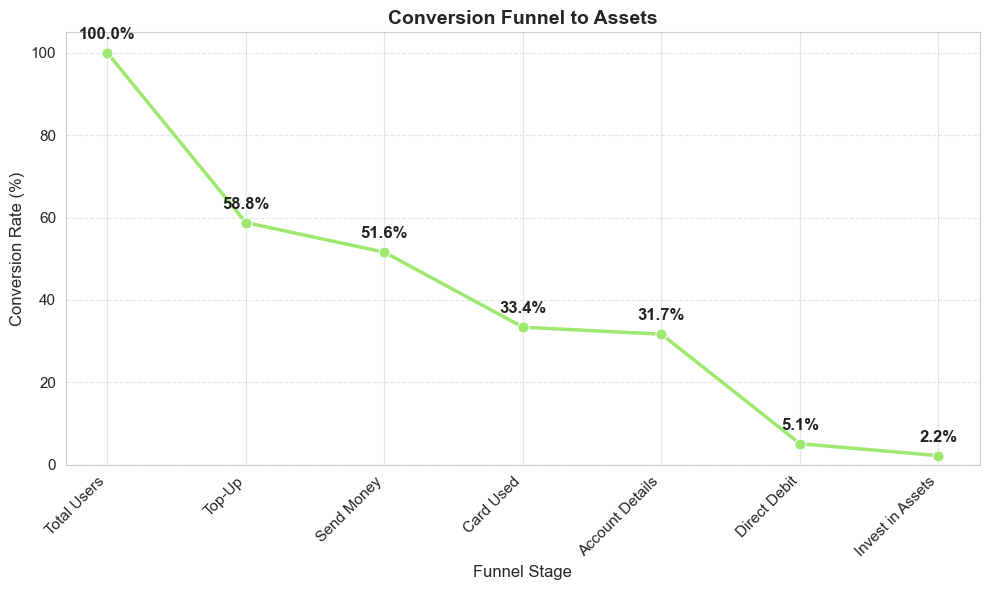

In [251]:
#Seaborn line plot visualizing conversion funnel stages

plt.figure(figsize=(10, 6))

# Add markers
sns.lineplot(x=steps, y=conversion_rates_list, marker="o", linestyle="-", markersize=8, linewidth=2.5, color=WISE_BRIGHT_GREEN)

# Add percentages
for i, rate in enumerate(conversion_rates_list):
    plt.annotate(f"{rate:.1f}%", (steps[i], rate), textcoords="offset points", xytext=(0, 10), ha='center', 
                 fontsize=12, fontweight="bold", color=WISE_DARK_CHARCOAL)

plt.title("Conversion Funnel to Assets", fontweight="bold")
plt.xlabel("Funnel Stage")
plt.ylabel("Conversion Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()


plt.show()


## **Conversion Funnel Analysis**
### **Major Drop-Off Points**  
| **Stage** | **Conversion Rate (%)** | **Fix & Impact** |
|-----------|----------------|-------------------------------------|
| **Sign-up → First Top-up** | 59% (-41%) | **Better onboarding + incentives** to recover up to **15% losses**. |
| **Top-up → Send Money** | 93% (-7%) | **Highlight Wise’s low fees & speed** at top-up confirmation. |
| **Send → Card Usage** | 75% (-18%) | **Push Wise card benefits** in post-transfer UI. |
| **Direct Debit → Assets** | **2.25%** (-3%) | **Auto-invest options + higher APY incentives**. |

💡 **Takeaway:** Fixing **top-ups** is the **fastest way** to increase Asset adoption.


## 🟩**b.** Factors driving conversion rates to Assets

## Personal vs. Business Users  

#### Why It Matters
- Business and personal users engage differently.  
- Businesses may invest more due to multi-currency needs.  
- If businesses convert higher, Wise should refine marketing to boost personal user adoption.  


In [238]:
# Conversion rates by user segment (Personal vs Business)
query = """
SELECT 
    class AS user_type,  -- Consumer vs. Business
    COUNT(profile_id) AS total_users,
    COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) AS asset_users,
    ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2) AS asset_conversion_rate
FROM profile_lifetime_activity
GROUP BY class;
"""

segment_analysis = pd.read_sql(query, conn)
segment_analysis


,user_type,total_users,asset_users,asset_conversion_rate
0,Business,1513,63,4.16
1,Personal,8487,162,1.91


#### Key Findings 
- **Business Users Convert More:** **4.16%** vs. **1.91%** for personal users.  
- **Personal Users Are the Majority:** They dominate Wise’s user base.  
- **Why?** Businesses hold larger balances and seek yield, making them more likely to invest.  

#### Business Implications
- **Target Personal Users:** Largest untapped opportunity.  
- **Incentives Needed:** Offer interest boosts or cashback to drive adoption.  


## Early vs. Late Users  

#### Why It Matters  
- **Higher conversion in newer users** suggests onboarding improvements are working.  
- **Lower adoption in older users** signals a need for re-engagement.  
- **Cohort insights** help refine marketing and product strategy.  


In [239]:
# Analyze asset conversion by user registration period
query = """
SELECT 
    CASE 
        WHEN strftime('%m', profile_created) IN ('01', '02', '03') THEN 'Q1'
        WHEN strftime('%m', profile_created) IN ('04', '05', '06') THEN 'Q2'
    END AS user_registration_quarter,
    COUNT(DISTINCT profile_id) AS total_users,
    COUNT(DISTINCT CASE WHEN first_assets IS NOT NULL THEN profile_id END) AS asset_users,
    ROUND(100.0 * COUNT(DISTINCT CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(DISTINCT profile_id), 2) AS asset_conversion_rate
FROM profile_lifetime_activity
GROUP BY user_registration_quarter
ORDER BY asset_conversion_rate DESC;


"""

registration_analysis = pd.read_sql(query, conn)
registration_analysis


,user_registration_quarter,total_users,asset_users,asset_conversion_rate
0,Q2,4926,124,2.52
1,Q1,5074,101,1.99


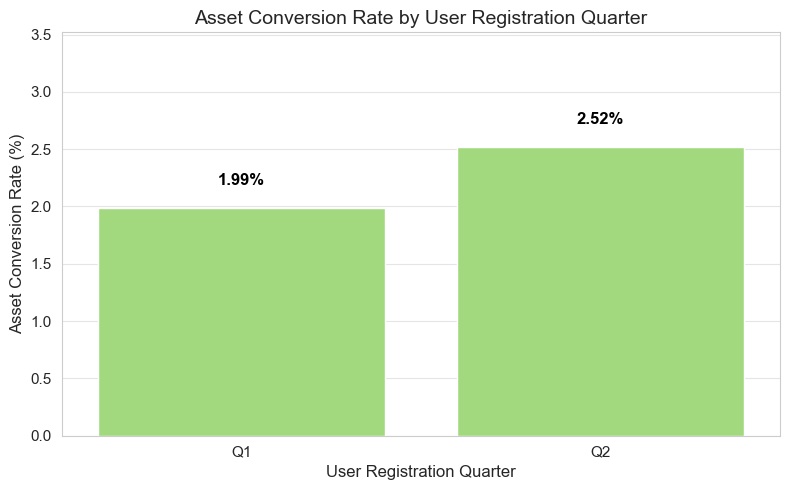

In [240]:
registration_analysis = pd.read_sql(query, conn)

# Convert query output to DataFrame
df = registration_analysis.sort_values("user_registration_quarter")

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="user_registration_quarter", y="asset_conversion_rate", data=df, color=WISE_BRIGHT_GREEN)

# Add percentages
for i, val in enumerate(df["asset_conversion_rate"]):
    ax.text(i, val + 0.2, f"{val:.2f}%", ha='center', fontsize=12, fontweight='bold', color="black")

plt.xlabel("User Registration Quarter")
plt.ylabel("Asset Conversion Rate (%)")
plt.title("Asset Conversion Rate by User Registration Quarter")
plt.ylim(0, max(df["asset_conversion_rate"]) + 1)  # add space above bars
plt.tight_layout()
plt.show()


#### Key Findings  
- **Newer users convert at higher rates:**  
  - **Q1:** **1.99%**  
  - **Q2:** **2.52%**  

- **Why?**  
  - **Improved onboarding** drives early engagement.  
  - **Recent marketing** better promotes Assets.  
  - New users are **more financially engaged** from the start.  

#### Business Implications  
- **Re-engage older users** via email and app notifications.  
- **Test time-limited incentives**: *“Invest in your first 90 days and get a bonus return!”*  


## Feature Usage (count) vs. Asset Conversion  

#### Why It Matters  
- **More engaged users invest more** → Wise should drive early feature adoption.  
- **Low-engagement users rarely invest** → Targeted nudges may increase activity.  
- **Identifying key features** can refine Wise’s marketing strategy.  


In [241]:
# Analyze conversion based on the number of Wise features used
query = """
WITH user_feature_counts AS (
    SELECT
        profile_id,
        -- Count the number of Wise features a user has engaged with
        ( 
          CASE WHEN first_send IS NOT NULL THEN 1 ELSE 0 END +
          CASE WHEN first_balance IS NOT NULL THEN 1 ELSE 0 END +
          CASE WHEN first_top_up IS NOT NULL THEN 1 ELSE 0 END +
          CASE WHEN first_account_details IS NOT NULL THEN 1 ELSE 0 END +
          CASE WHEN first_direct_debit IS NOT NULL THEN 1 ELSE 0 END +
          CASE WHEN first_card IS NOT NULL THEN 1 ELSE 0 END
        ) AS feature_count,
        first_assets  -- Track users who invested in assets
    FROM profile_lifetime_activity
)

SELECT
    CASE 
      WHEN feature_count = 0 THEN 'No Features Used'
      WHEN feature_count BETWEEN 1 AND 2 THEN 'Low Engagement (1-2 Features)'
      WHEN feature_count BETWEEN 3 AND 4 THEN 'Medium Engagement (3-4 Features)'
      ELSE 'High Engagement (5-6 Features)'
    END AS engagement_level,
    COUNT(profile_id) AS total_users,
    COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) AS asset_users,
    ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2) AS asset_conversion_rate
FROM user_feature_counts
GROUP BY engagement_level
ORDER BY asset_conversion_rate DESC;


"""

engagement_level_analysis = pd.read_sql(query, conn)
engagement_level_analysis


,engagement_level,total_users,asset_users,asset_conversion_rate
0,High Engagement (5-6 Features),700,44,6.29
1,Medium Engagement (3-4 Features),3974,167,4.20
2,Low Engagement (1-2 Features),5314,14,0.26
3,No Features Used,12,0,0.00


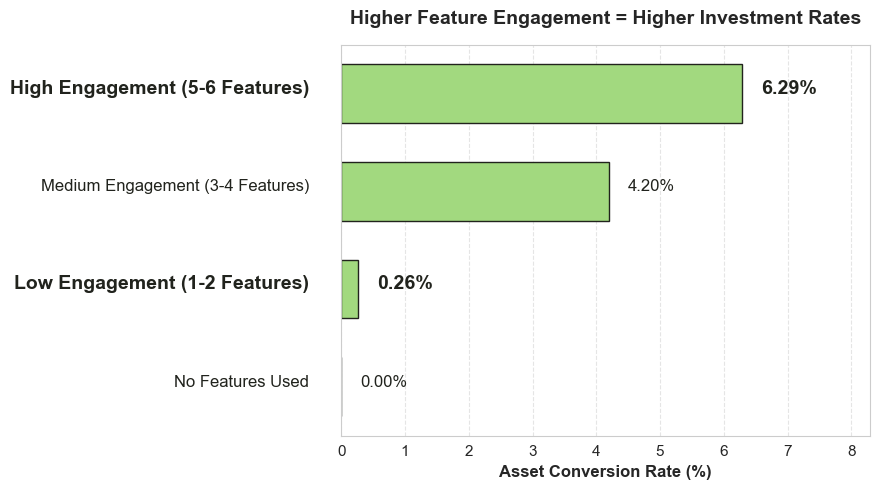

In [253]:
plt.figure(figsize=(9, 5))


ax = sns.barplot(
    y="engagement_level", 
    x="asset_conversion_rate", 
    data=engagement_level_analysis,
    color=WISE_BRIGHT_GREEN, 
    edgecolor=WISE_DARK_CHARCOAL,
    width=0.6 
)

# Make "High Engagement" and "Low Engagement" Bold
for i, val in enumerate(engagement_level_analysis["asset_conversion_rate"]): 
    label = engagement_level_analysis["engagement_level"].iloc[i] 
    font_size = 14 if label in ["High Engagement (5-6 Features)", "Low Engagement (1-2 Features)"] else 12
    font_weight = "bold" if label in ["High Engagement (5-6 Features)", "Low Engagement (1-2 Features)"] else "normal"

    ax.text(val + 0.3, i, f"{val:.2f}%", ha='left', fontsize=font_size, fontweight=font_weight, color=WISE_DARK_CHARCOAL)
    ax.text(-0.5, i, label, ha="right", fontsize=font_size, fontweight=font_weight, color=WISE_DARK_CHARCOAL)

plt.xlabel("Asset Conversion Rate (%)", fontsize=12, fontweight="bold")

plt.ylabel("")
plt.title("Higher Feature Engagement = Higher Investment Rates", fontsize=14, fontweight="bold", pad=15)

plt.xlim(0, max(engagement_level_analysis["asset_conversion_rate"]) + 2)
plt.xticks(fontsize=11)
plt.yticks([])  
plt.grid(axis='x', linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


## **Feature Engagement & Asset Conversion**  

#### **Key Findings**  
| **Feature Engagement Level** | **Asset Conversion Rate (%)** |
|----------------------------|-----------------------------|
| **5-6 features** | **6.29%** |
| **3-4 features** | **4.20%** |
| **1-2 features** | **0.26%** |
| **0 features** | **0.00%** |

#### **Impact of Feature Adoption**  
- Moving from **1-2 to 3-4 features** increases conversion **from 0.26% to 4.20%**.  
- Users with **5-6 features convert 24x more than users with 1-2 features**.  

#### **Business Implications**  
- Encourage feature adoption early to drive investment.  
- Nurture medium-engagement users with investment nudges.  
- Offer exclusive benefits to high-engagement users.  
- Incentivize low-engagement users with fee discounts or first-time bonuses.  


## Feature Usage (type) vs. Asset Conversion  
This section examines how specific Wise features influence investment behavior. 
#### Why It Matters  
- Certain features may drive **higher investment conversion**.  
- Identifying these features helps Wise **prioritize promotion**.  
- Users engaging with key features may be **better investment targets**.  


In [243]:
# SQL query to analyze asset conversion rates by specific feature usage
query = """
WITH feature_analysis AS (
    SELECT 
        'First Direct Debit Usage' AS feature,
        COUNT(profile_id) AS total_users,
        COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) AS asset_users,
        ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2) AS asset_conversion_rate
    FROM profile_lifetime_activity
    WHERE first_direct_debit IS NOT NULL
    
    UNION ALL
    
    SELECT 
        'First Account Details Requested',
        COUNT(profile_id),
        COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END),
        ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2)
    FROM profile_lifetime_activity
    WHERE first_account_details IS NOT NULL

    UNION ALL

    SELECT 
        'First Card Usage',
        COUNT(profile_id),
        COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END),
        ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2)
    FROM profile_lifetime_activity
    WHERE first_card IS NOT NULL

    UNION ALL

    SELECT 
        'First Top-Up & Balance',
        COUNT(profile_id),
        COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END),
        ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2)
    FROM profile_lifetime_activity
    WHERE first_top_up IS NOT NULL AND first_balance IS NOT NULL

    UNION ALL

    SELECT 
        'First Send Money',
        COUNT(profile_id),
        COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END),
        ROUND(100.0 * COUNT(CASE WHEN first_assets IS NOT NULL THEN profile_id END) / COUNT(profile_id), 2)
    FROM profile_lifetime_activity
    WHERE first_send IS NOT NULL
)

SELECT * FROM feature_analysis ORDER BY asset_conversion_rate DESC;

"""
feature_conversion = pd.read_sql(query, conn)
feature_conversion


,feature,total_users,asset_users,asset_conversion_rate
0,First Direct Debit Usage,507,41,8.09
1,First Account Details Requested,3172,174,5.49
2,First Card Usage,3336,171,5.13
3,First Top-Up & Balance,5879,225,3.83
4,First Send Money,5165,36,0.70


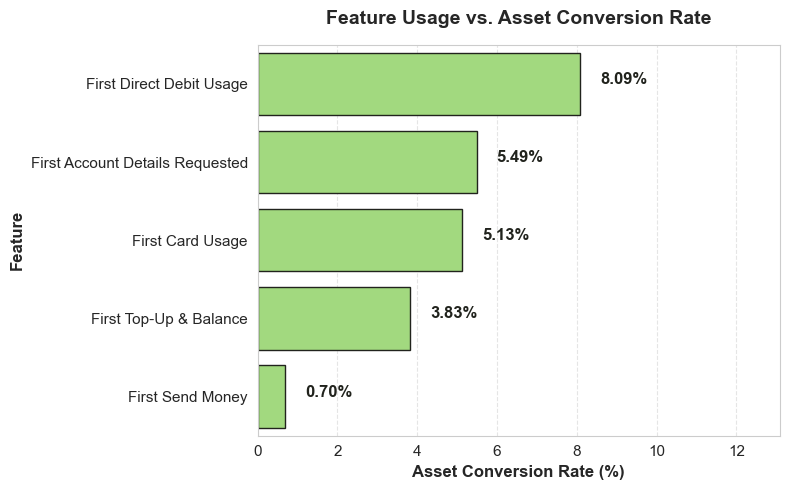

In [244]:
feature_conversion = feature_conversion.sort_values(by="asset_conversion_rate", ascending=False)

plt.figure(figsize=(8, 5))

ax = sns.barplot(
    x="asset_conversion_rate", 
    y="feature", 
    data=feature_conversion, 
    color=WISE_BRIGHT_GREEN, 
    edgecolor=WISE_DARK_CHARCOAL
)

# Add percentages
for i, val in enumerate(feature_conversion["asset_conversion_rate"]):
    ax.text(val + 0.5, i, f"{val:.2f}%", ha='left', fontsize=12, fontweight='bold', color=WISE_DARK_CHARCOAL)

plt.xlabel("Asset Conversion Rate (%)", fontsize=12, fontweight="bold")
plt.ylabel("Feature", fontsize=12, fontweight="bold")
plt.title("Feature Usage vs. Asset Conversion Rate", fontsize=14, fontweight="bold", pad=15)

plt.xlim(0, max(feature_conversion["asset_conversion_rate"]) + 5)  # Extra space for labels
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


#### Key Findings  
- **Direct Debit users convert the most (8.09%)** → Strongest investment link.  
- **Account Details users (5.49%)** → Setup engagement correlates with investing.  
- **Card Users (5.13%)** → Financially engaged but need more incentives.  
- **Top-Up & Balance users (3.83%)** → View Wise as a spending tool.  
- **Send Money-first users (0.70%)** → Least likely to invest.  

#### Takeaway  
- **Direct Debit and Account Details usage** signal higher investment potential.  
- **Send Money-first users are unlikely to invest.**  


---

---



## 🟩 Forecasting Asset Adoption  

#### Why It Matters  
- Anticipates **future demand** for Assets.  
- Identifies **growth trends** and slowdowns.  
- Informs **marketing and acquisition strategies**.  


In [245]:
# SQL query to extract the number of customers who invested in assets per month
query = """
SELECT 
    strftime('%Y-%m', FIRST_ASSETS) AS month,
    COUNT(PROFILE_ID) AS new_asset_customers
FROM profile_lifetime_activity
WHERE FIRST_ASSETS IS NOT NULL
GROUP BY month
ORDER BY month;
"""

new_asset_customers = pd.read_sql(query, conn)

# Convert to datetime format
new_asset_customers["month"] = pd.to_datetime(new_asset_customers["month"])
new_asset_customers.set_index("month", inplace=True)
new_asset_customers


,new_asset_customers
month,
2023-01-01,11
2023-02-01,9
2023-03-01,9
2023-04-01,12
2023-05-01,19
2023-06-01,37
2023-07-01,30
2023-08-01,25
2023-09-01,28


In [255]:
# Applying Holt-Winters model
model = ExponentialSmoothing(
    new_asset_customers["new_asset_customers"], 
    trend="add", 
    seasonal="add",  # Additive seasonality
    seasonal_periods=6,  # semi-annual seasonality
    damped_trend=True  # Prevents unrealistic exponential growth
)

fit = model.fit(optimized=True)

forecast_index = pd.date_range(start=new_asset_customers.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")
forecast_values = fit.forecast(steps=12)

forecast_df = pd.DataFrame({"month": forecast_index, "forecasted_customers": forecast_values})

print(forecast_df.to_string(index=False))



     month  forecasted_customers
2024-02-29                  9.15
2024-03-31                  9.84
2024-04-30                  2.98
2024-05-31                  4.46
2024-06-30                 15.21
2024-07-31                 13.70
2024-08-31                  8.91
2024-09-30                  9.65
2024-10-31                  2.82
2024-11-30                  4.33
2024-12-31                 15.11
2025-01-31                 13.62


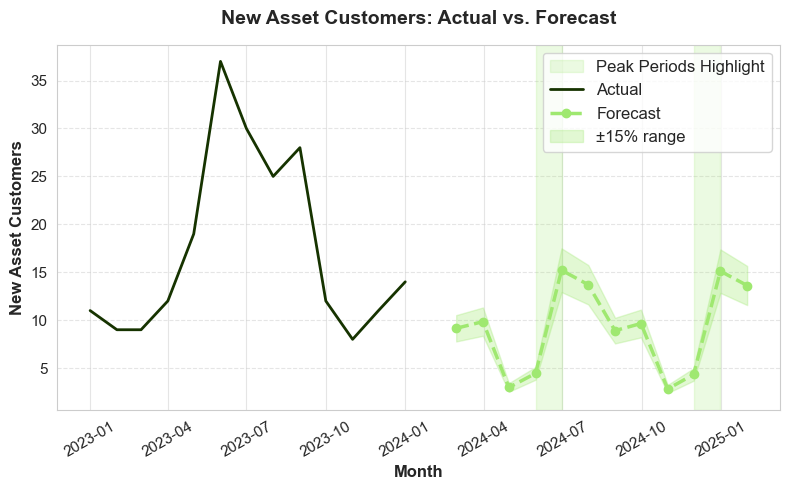

In [256]:

plt.figure(figsize=(8, 5))
ax = plt.gca()

# Highlight Peak Periods (June & December)
ax.axvspan(pd.Timestamp("2024-06-01"), pd.Timestamp("2024-06-30"), 
           color=WISE_BRIGHT_GREEN, alpha=0.2)
ax.axvspan(pd.Timestamp("2024-12-01"), pd.Timestamp("2024-12-31"), 
           color=WISE_BRIGHT_GREEN, alpha=0.2, label="Peak Periods Highlight")

# Plot historical trend
plt.plot(new_asset_customers.index, new_asset_customers["new_asset_customers"], 
         label="Actual", color=WISE_FOREST_GREEN, linewidth=2)

# Plot forecasted values
plt.plot(forecast_df["month"], forecast_df["forecasted_customers"], 
         label="Forecast", color=WISE_BRIGHT_GREEN, linestyle="--", marker="o", linewidth=2.5)

# Confidence interval shading (±15%)
plt.fill_between(forecast_df["month"], 
                 forecast_df["forecasted_customers"] * 0.85, 
                 forecast_df["forecasted_customers"] * 1.15, 
                 color=WISE_BRIGHT_GREEN, alpha=0.3, label="±15% range")

# Labels & Title
plt.xlabel("Month", fontsize=12, fontweight="bold")
plt.ylabel("New Asset Customers", fontsize=12, fontweight="bold")
plt.title("New Asset Customers: Actual vs. Forecast", fontsize=14, fontweight="bold", pad=15)

# Style Adjustments
plt.legend(loc="upper right")
plt.xticks(fontsize=11, rotation=30)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


#### Key Observations  
- **Peak:** **June 2023 (37 users)**, sharp drop in **Q4 2023 (8 users in November)**.  
- **Recovery:** **January 2024 (14 users)**, but volatility remains.  
- **Forecast:** **Q2 2024 dip (~3 users in April), rebound in June (15 users)**.  
- **Pattern:** **Peaks in June & December, dips in Q2/Q4**.  

#### Takeaways  
- **June & December peaks** → Align marketing efforts.  
- **Q2 2024 dip** → Needs intervention.  
- **Growth fluctuates** → External factors (marketing, economy) impact adoption.  

#### Limitations  
- **Market shifts affect trends.**  
- **Patterns may change.**  
- **Limited data.**  


---

---



## 🟩 Forecasting Total Holdings

#### Why It Matters  
- Tracks **asset investment trends**.  
- Identifies **revenue growth potential**.  
- Supports **product and liquidity planning**.  


In [248]:
# extract total asset holdings per month
query = """
SELECT 
    strftime('%Y-%m', month_balance) AS month,
    SUM(end_total_holdings_gbp) AS total_holdings
FROM profile_historical_holdings_monthly
GROUP BY month
ORDER BY month;
"""

total_holdings = pd.read_sql(query, conn)

total_holdings["month"] = pd.to_datetime(total_holdings["month"])

total_holdings.set_index("month", inplace=True)

#Convert and display in M£ format
total_holdings["total_holdings"] = total_holdings["total_holdings"] / 1e6
print(total_holdings.to_string(formatters={"total_holdings": lambda x: f"{x:.2f}M"}))


           total_holdings
month                    
2023-01-01          0.23M
2023-02-01          0.84M
2023-03-01          2.02M
2023-04-01          3.10M
2023-05-01          5.28M
2023-06-01          6.77M


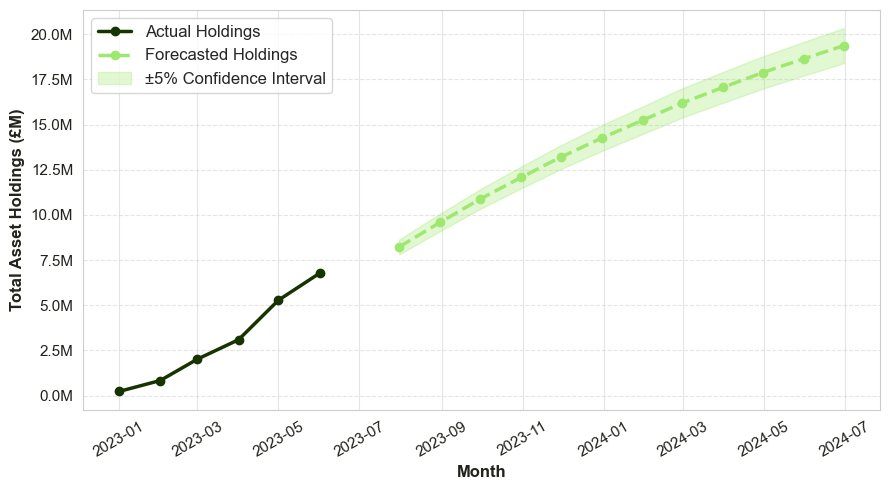

     month forecasted_holdings
2023-07-31               8.23M
2023-08-31               9.60M
2023-09-30              10.88M
2023-10-31              12.08M
2023-11-30              13.21M
2023-12-31              14.27M
2024-01-31              15.26M
2024-02-29              16.19M
2024-03-31              17.06M
2024-04-30              17.88M
2024-05-31              18.65M
2024-06-30              19.37M


In [257]:
# Extract total asset holdings per month
query = """
SELECT 
    strftime('%Y-%m', month_balance) AS month,
    SUM(end_total_holdings_gbp) AS total_holdings
FROM profile_historical_holdings_monthly
GROUP BY month
ORDER BY month;
"""

total_holdings = pd.read_sql(query, conn)
total_holdings["month"] = pd.to_datetime(total_holdings["month"])
total_holdings.set_index("month", inplace=True)
total_holdings["total_holdings"] = total_holdings["total_holdings"] / 1e6  

# Fit ARIMA(1,1,1) model
model = ARIMA(total_holdings["total_holdings"], order=(1, 1, 1))
fit = model.fit()

# Generate 12-month forecast
forecast_index = pd.date_range(start=total_holdings.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")
forecast_values = fit.forecast(steps=12)

forecast_df = pd.DataFrame({"month": forecast_index, "forecasted_holdings": forecast_values})

# --- PLOTTING ---
plt.figure(figsize=(9, 5))
plt.plot(total_holdings.index, total_holdings["total_holdings"], 
         marker="o", linestyle="-", label="Actual Holdings", 
         color=WISE_FOREST_GREEN, linewidth=2.5)

plt.plot(forecast_df["month"], forecast_df["forecasted_holdings"], 
         marker="o", linestyle="--", label="Forecasted Holdings", 
         color=WISE_BRIGHT_GREEN, linewidth=2.5)

plt.fill_between(
    forecast_df["month"],
    forecast_df["forecasted_holdings"] * 0.95,  
    forecast_df["forecasted_holdings"] * 1.05,  
    color=WISE_BRIGHT_GREEN, alpha=0.3, label="±5% Confidence Interval"
)


plt.xlabel("Month", fontsize=12, fontweight="bold", color=WISE_DARK_CHARCOAL)
plt.ylabel("Total Asset Holdings (£M)", fontsize=12, fontweight="bold", color=WISE_DARK_CHARCOAL)
#plt.title("Historical vs. Forecasted Wise Asset Holdings (ARIMA)", fontsize=14, fontweight="bold", pad=15, color=WISE_DARK_CHARCOAL)

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.1f}M"))

plt.legend(loc="upper left")
plt.xticks(fontsize=11, rotation=30, color=WISE_DARK_CHARCOAL)
plt.yticks(fontsize=11, color=WISE_DARK_CHARCOAL)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()

forecast_df["forecasted_holdings"] = forecast_df["forecasted_holdings"]  
print(forecast_df.to_string(index=False, formatters={"forecasted_holdings": lambda x: f"{x:.2f}M"}))


## Forecasting Wise Total Holdings – Insights  

#### Growth Trends  
- **Total holdings grew from £0.23M (Jan 2023) to £6.77M (Jun 2023)**.  
- **Forecast: £19.37M by June 2024**, with consistent month-over-month increases.  
- **£1M MoM growth**.  

#### Takeaways  
- **Sustained, predictable growth** supports long-term asset adoption.  
- **No sharp spikes or declines**, indicating stable investor confidence.  
- **Liquidity planning is key** as holdings approach **£20M**.  

#### Limitations  
- **Market conditions may shift growth patterns**.  
- **Does not account for segmentation (business vs. personal users)**.  
- **Future adoption may vary based on economic factors**.  
